# Trayectorias de Desarrollo




In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import os
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold
import statsmodels.api as sm
import time
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from google.colab import drive 



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# defino funciones

def risk_calculation(pond, df, var_socioec, var_salud, var_antrp, ronda):
    dict_dfs = dict()
    if pond == 'standar':
        #var_target = var_socioec + var_salud + var_antrp
        data_ronda = df[df.ronda == ronda].sort_values(by = 'childid').dropna(axis=1, how='all')
        var_socioec = [i for i in var_socioec if i in data_ronda.columns]
        var_salud = [i for i in var_salud if i in data_ronda.columns]
        var_antrp = [i for i in var_antrp if i in data_ronda.columns]
        var_target = var_socioec + var_salud + var_antrp
        pond_socioec  = 1/len(var_socioec)
        pond_salud = 1/len(var_salud)
        pond_antrp = 1/len(var_antrp)
        print('ronda:',ronda)
        print('var_socioec:',var_socioec, 'pond_socioec:',pond_socioec)
        print('var_salud:',var_salud,'pond_salud:',pond_salud)
        print('var_antrp:',var_antrp, 'pond_antrp:',pond_antrp)
        print(' ')
        min_max_scaler = MinMaxScaler() 
        data_ronda.loc[:,var_target] = min_max_scaler.fit_transform(data_ronda.loc[:,var_target])
        score_salud = (data_ronda.loc[:,var_salud] * pond_salud).sum(axis=1); score_salud.name = 'score_antrp'
        score_antrp = (data_ronda.loc[:,var_antrp] * pond_antrp).sum(axis=1); score_antrp.name = 'score_salud'
        score_socioec = (data_ronda.loc[:,var_socioec] * pond_socioec).sum(axis=1); score_socioec.name = 'score_socioec'
        score_final = (1/3) * score_salud + (1/3) * score_antrp + (1/3) * score_socioec ; score_final.name = 'risk'
        #data_ronda["risk"] = score_final
        #data_ronda["risk"] = np.where(data_ronda.deceased == 1, 1, data_ronda.risk)
        final_scores = pd.concat([score_salud,score_antrp,score_socioec,score_final],axis = 1)
            
    else:
        print("need to adjust manually")
    return final_scores;

def risk_assign(pond, df, var_socioec, var_salud, var_antrp):
    rondas = list(df.ronda.unique())
    dicts_df = dict()
    for i in rondas:
        data_ronda = pd.DataFrame()
        data_ronda = df[df.ronda == i]#.sort_values(by = 'childid')
        final_scores = risk_calculation(pond, data_ronda, var_socioec, var_salud, var_antrp, i)
        new_df = pd.concat([data_ronda,final_scores],axis = 1)
        new_df['risk'] = np.where(new_df.deceased == 1,1,new_df.risk)
        dicts_df[str(i)] = new_df
    return dicts_df;

def compare_hist_per_round(var1,var2,var3,var4,var5,title,bins =20):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.hist(var1, bins=bins, color='lightblue')
    plt.xlim(0,1)
    plt.title("Ronda 1")
    
    plt.subplot(2, 3, 2)
    plt.hist(var2, bins=bins, color='lightblue')
    plt.xlim(0,1)
    plt.title("Ronda 2")
    
    plt.subplot(2, 3, 3)
    plt.hist(var3, bins=bins, color='lightblue')
    plt.xlim(0,1)
    plt.title("Ronda 3")
    
    plt.subplot(2, 3, 4)
    plt.hist(var4, bins=bins, color='lightblue')
    plt.xlim(0,1)
    plt.title("Ronda 4")
    
    plt.subplot(2, 3, 5)
    plt.hist(var5, bins=bins, color='lightblue')
    plt.xlim(0,1)
    plt.title("Ronda 5")
    
    plt.suptitle(title)
    plt.show();


def roc_curve_plot(y_test, y_prob, data_set = None):
    fpr_log,tpr_log,thr_log = roc_curve(y_test, y_prob)
    df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve')
    plt.plot(df['fpr'],df['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    
    if data_set == 'train':
        return print('AUC train =', auc(fpr_log, tpr_log))
    elif data_set == 'test':
        return print('AUC test =', auc(fpr_log, tpr_log))
    else:
        return print('AUC =', auc(fpr_log, tpr_log))
    ;

Carga de dataset

In [3]:
# importo los datos
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Tesis/df_final.csv', na_values=' ')
df.rename(columns = {'round': 'ronda'}, inplace = True)
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,maths_raw,ppvt_raw,rawscre,reading_raw,sppvt_raw,srawscre,score_cog,rscorelang_cog,rscorelang_ppvt,score_ppvt
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PE011001,1,2,1,1,NaN,3/26/2007,PE01C01,1.000,1.000,...,NaN,NaN,22.000,NaN,NaN,NaN,9.000,305.212,280.317,22.000
2,PE011001,1,3,1,1,NaN,8/10/2009,PE01C01,1.000,1.000,...,21.000,80.000,80.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PE011001,1,4,1,1,NaN,8/8/2013,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PE011001,1,5,1,1,NaN,8/11/2016,PE01C01,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(10260, 227)

In [8]:
df.groupby('ronda')['childid'].count()

ronda
1    2052
2    2052
3    2052
4    2052
5    2052
Name: childid, dtype: int64

## 1- Modificaciones y transformaciones para interpretar mejora la data

In [9]:
# modifico las variables para el target para que a mayor valor, mayor riesgo
# CATEGORICAS

df.chsex = np.where(df.chsex == 2,0,1) 

df.headsex = np.where(df.headsex == 2,0,1) 

df.caresex = np.where(df.caresex == 2,0,1) 

df['chhrel_mod'] = np.where(df.chhrel == 3,1,0)  # marco solo el caso "Worse", no el de "Same" o "Better"

df['bmi_cat'] = 0
df.loc[df.bmi < 18.5 , "bmi_cat"] = 2
df.loc[(df.bmi >= 18.5) & (df.bmi <22), "bmi_cat"] = 0
df.loc[(df.bmi >= 22) & (df.bmi <24.9) , "bmi_cat"] = 1
df.loc[(df.bmi >= 24.9) & (df.bmi <29.9) , "bmi_cat"] = 2
df.loc[(df.bmi >=29.9) , "bmi_cat"] = 3

# CONTINUAS
df["wi"] = ((df["wi"] - 1) * -1)
df["hq"] = ((df["hq"] - 1) * -1)
df["cd"] = ((df["cd"] - 1) * -1)
df["sv"] = ((df["sv"] - 1) * -1)

df.loc[df["wi"].isna(),'wi'] = 1
df.loc[df["hq"].isna(),'hq'] = 1
df.loc[df["cd"].isna(),'cd'] = 1
df.loc[df["sv"].isna(),'sv'] = 1

# paso a int la unica variable que quedó en formato "objeto"
df.hospital.replace(['Yes', 'No'],[0,1], inplace=True)

## 2- Definición de las variables a utilizar para calcular el riesgo


In [10]:
# variables que componen el target
var_socioec_cat = []
var_socioec_cont  = ['wi',"hq","cd","sv"]
var_socioec = var_socioec_cont + var_socioec_cat

var_salud_cat = ["chhrel","chmightdie","deceased",'chillness','chinjury']
var_salud_cont = []
var_salud = var_salud_cat + var_salud_cont

var_familia_cat = []
var_familia_cont = []
var_familia = var_familia_cat + var_familia_cont

var_antrp_cat = ['stunting',"bmi_cat"]
var_antrp_cont = []
var_antrp = var_antrp_cat + var_antrp_cont

df.loc[:, df.dtypes == object].head()


# VER ONE HOT ENCODER
# Paso a dummy variables PREDICTORAS que son NO ordinales. 
dummie_list = ["headrel","carerel","carehead","entype","chrephealth4",'chdisscale',"region"]
dummies = pd.concat([pd.get_dummies(df[col]) for col in dummie_list], axis=1, keys=dummie_list)
dummies.columns = ["headrel_0","headrel_1","headrel_2","headrel_3","headrel_4","headrel_5","headrel_6","headrel_7","headrel_8","headrel_9","carerel_1","carerel_2","carerel_3","carerel_4","carerel_5","carerel_6","carerel_7","carerel_9","carehead_1","carehead_2","carehead_3","entype_1","entype_2","entype_3","entype_4","chrephealth4_1","chrephealth4_2","chrephealth4_3","chrephealth4_4","chdisscale_0","chdisscale_1","chdisscale_2","chdisscale_3","chdisscale_4","chdisscale_5","chdisscale_6","region_31","region_32","region_33","region_88"]
#dummies.columns = ["headrel_1","headrel_2","headrel_3","headrel_4","headrel_5","headrel_6","headrel_7","headrel_8","headrel_9","carerel_2","carerel_3","carerel_4","carerel_5","carerel_6","carerel_7","carerel_9","carehead_2","carehead_3","entype_2","entype_3","entype_4","chrephealth4_2","chrephealth4_3","chrephealth4_4","chdisscale_1","chdisscale_2","chdisscale_3","chdisscale_4","chdisscale_5","chdisscale_6","region_32","region_33","region_88"]
df_with_dummies = pd.concat([df,dummies],axis = 1)
df_with_dummies

,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,chdisscale_1,chdisscale_2,chdisscale_3,chdisscale_4,chdisscale_5,chdisscale_6,region_31,region_32,region_33,region_88
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,0,0,0,0,0,0,1,0,0,0
1,PE011001,1,2,1,1,NaN,3/26/2007,PE01C01,1.000,1.000,...,0,0,0,0,0,0,1,0,0,0
2,PE011001,1,3,1,1,NaN,8/10/2009,PE01C01,1.000,1.000,...,0,0,0,0,0,0,1,0,0,0
3,PE011001,1,4,1,1,NaN,8/8/2013,PE01C01,1.000,1.000,...,0,0,0,0,0,0,1,0,0,0
4,PE011001,1,5,1,1,NaN,8/11/2016,PE01C01,1.000,1.000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10255,PE201102,1,4,0,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
10256,PE201102,1,1,1,0,NaN,9/13/2002,PE20C01,20.000,1.000,...,0,0,0,0,0,0,0,1,0,0
10257,PE201102,1,2,1,0,NaN,3/8/2007,PE20C04,20.000,1.000,...,0,0,0,0,0,0,0,1,0,0
10258,PE201102,1,3,0,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


## 2.b- Se explora en mayor detalle una a una las variables que componen el target.
* ver en que rondas estan nulas
* explorar distribuciones


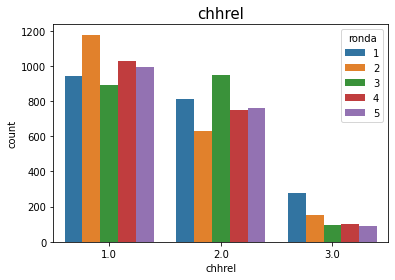

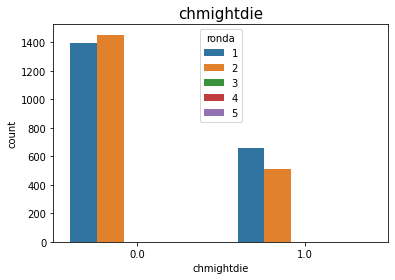

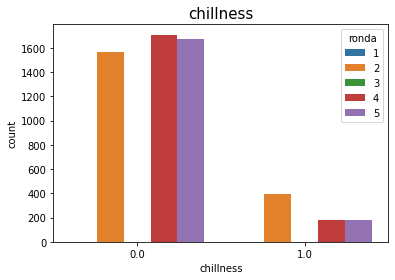

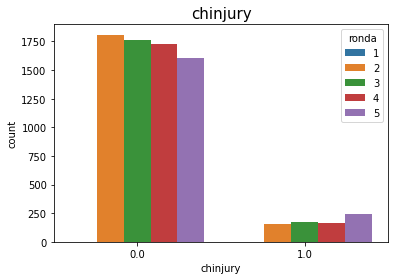

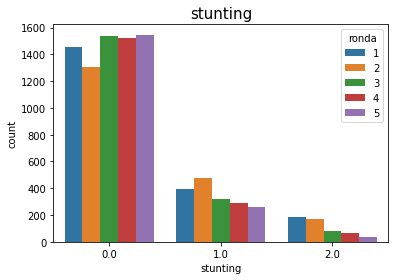

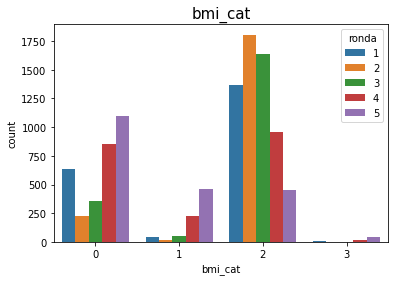

In [11]:
# se examinan las variables categoricas

var_target_cat = var_socioec_cat + var_salud_cat + var_antrp_cat
for i in var_target_cat:
  if i != 'deceased':
    ax = sns.countplot(x=i, data=df_with_dummies,hue='ronda')
    ax.set_title(i, fontsize=15)
    plt.show()
    print("")

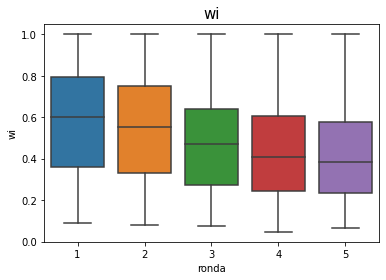

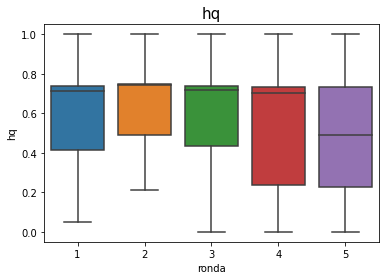

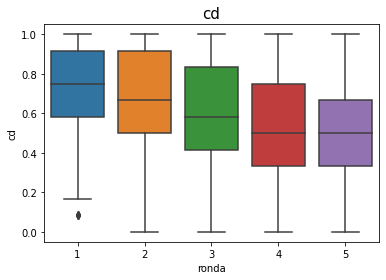

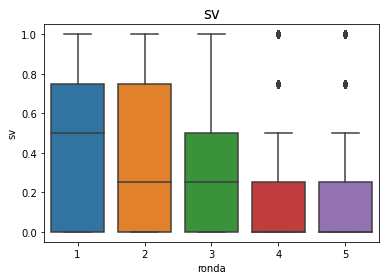

In [12]:
# se examinan las variables continuas
var_target_cont = var_socioec_cont + var_salud_cont + var_antrp_cont
for variables in var_target_cont:
  ax = sns.boxplot(x = 'ronda', y=variables, data=df_with_dummies)
  ax.set_title(variables, fontsize=15)
  plt.show()
  print("")


In [13]:
# para ver evaluar los estadisticos de tendencia cetral para cada variable, se utiliza el metodo describe.
var_target = var_socioec + var_salud + var_antrp
for variables in var_target:
  print(df_with_dummies.loc[:,['ronda'] + [variables]].groupby('ronda').describe(include = 'all'))
  print("")

            wi                                          
         count  mean   std   min   25%   50%   75%   max
ronda                                                   
1     2052.000 0.577 0.238 0.090 0.359 0.603 0.796 1.000
2     2052.000 0.551 0.246 0.078 0.332 0.555 0.749 1.000
3     2052.000 0.488 0.239 0.073 0.274 0.469 0.641 1.000
4     2052.000 0.453 0.245 0.047 0.245 0.410 0.603 1.000
5     2052.000 0.438 0.258 0.064 0.235 0.382 0.575 1.000

            hq                                           
         count  mean   std    min   25%   50%   75%   max
ronda                                                    
1     2052.000 0.592 0.252  0.051 0.412 0.713 0.737 1.000
2     2052.000 0.633 0.251  0.213 0.490 0.742 0.747 1.000
3     2052.000 0.593 0.258 -0.000 0.437 0.718 0.737 1.000
4     2052.000 0.571 0.273 -0.000 0.235 0.703 0.735 1.000
5     2052.000 0.545 0.285 -0.000 0.230 0.488 0.735 1.000

            cd                                           
         count  mean

## 3- Calculo el Riesgo por Round
* Se obtiene la medida final de riesgo para cada observacion.
* ! Notar que cuando una variable está completamente nula en una ronda, la misma no se utiliza para calcular el riesgo de esa ronda en particular.

In [14]:
dfs = risk_assign(pond = 'standar', df = df_with_dummies,
                  var_socioec = var_socioec, var_salud = var_salud, var_antrp = var_antrp
                  )
dfs.keys()

ronda: 1
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'chmightdie'] pond_salud: 0.5
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 2
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'chmightdie', 'deceased', 'chillness', 'chinjury'] pond_salud: 0.2
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 3
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'deceased', 'chinjury'] pond_salud: 0.3333333333333333
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 4
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'deceased', 'chillness', 'chinjury'] pond_salud: 0.25
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 
ronda: 5
var_socioec: ['wi', 'hq', 'cd', 'sv'] pond_socioec: 0.25
var_salud: ['chhrel', 'deceased', 'chillness', 'chinjury'] pond_salud: 0.25
var_antrp: ['stunting', 'bmi_cat'] pond_antrp: 0.5
 


dict_keys(['1', '2', '3', '4', '5'])

In [16]:
# divido las rondas en deciles

#r1["risk_cat_1"] = pd.qcut(r1["risk"] , 10,labels = False)
#r2["risk_cat_2"] = pd.qcut(r2["risk"] , 10,labels = False)
#r3["risk_cat_3"] = pd.qcut(r3["risk"] , 10,labels = False)
#r4["risk_cat_4"] = pd.qcut(r4["risk"] , 10,labels = False)
#r5["risk_cat_5"] = pd.qcut(r5["risk"] , 10,labels = False)

## 3b- Visualizo la distribucion del indice de riesgo por ronda

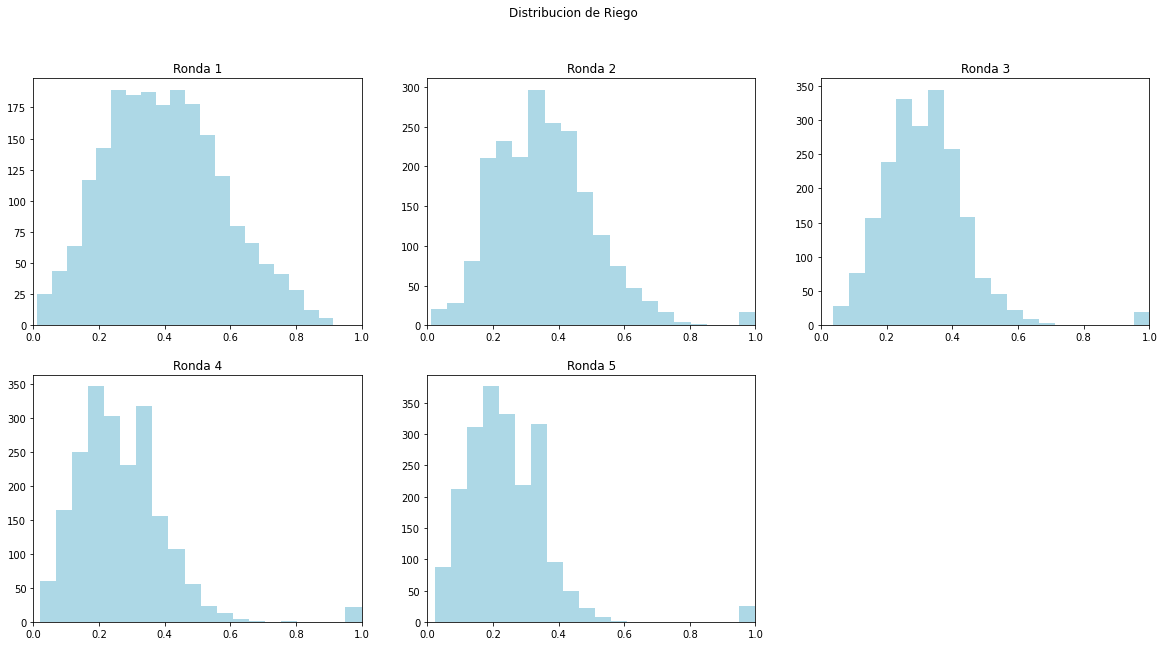

In [15]:


compare_hist_per_round(dfs['1']['risk'],
             dfs['2']['risk'],
             dfs['3']['risk'],
             dfs['4']['risk'],
             dfs['5']['risk'],
             'Distribucion de Riego',20)

In [16]:
# armo un dataset final en donde hay 1 solo frame con los datos de todas las rondas (formato "long")
df_final = pd.DataFrame()
for i in dfs.keys():
    df_final = pd.concat([df_final,dfs[i]], axis = 0)
print(df_final.shape)
df_final.head(5)

(10260, 273)


,childid,yc,ronda,inround,panel12345,deceased,dint,placeid,clustid,typesite,...,chdisscale_5,chdisscale_6,region_31,region_32,region_33,region_88,score_antrp,score_salud,score_socioec,risk
0,PE011001,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,0,0,1,0,0,0,0.500,0.333,0.727,0.520
5,PE011002,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,0,0,1,0,0,0,0.000,0.333,0.526,0.286
12,PE011003,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,0,0,1,0,0,0,0.750,0.000,0.315,0.355
15,PE011004,1,1,1,1,NaN,9/2/2002,PE01C01,1.000,1.000,...,0,0,1,0,0,0,0.500,0.000,0.220,0.240
22,PE011005,1,1,1,1,NaN,9/3/2002,PE01C01,1.000,1.000,...,0,0,1,0,0,0,0.500,0.583,0.824,0.636


## 3c- Evolucion de los distintos tipos de riesgo a traves del tiempo

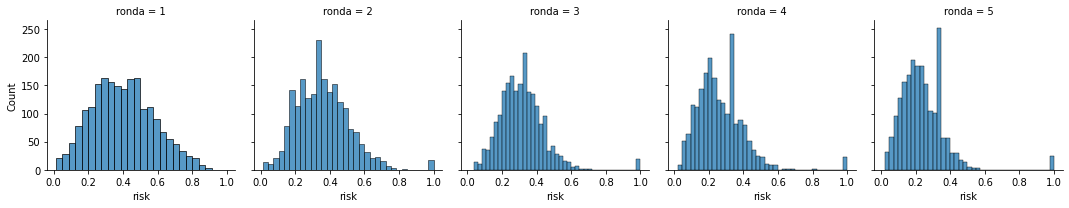

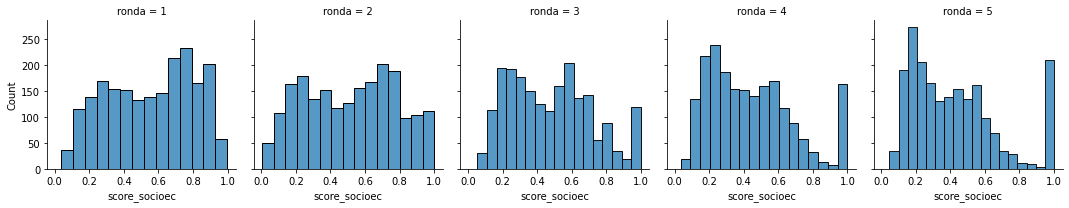

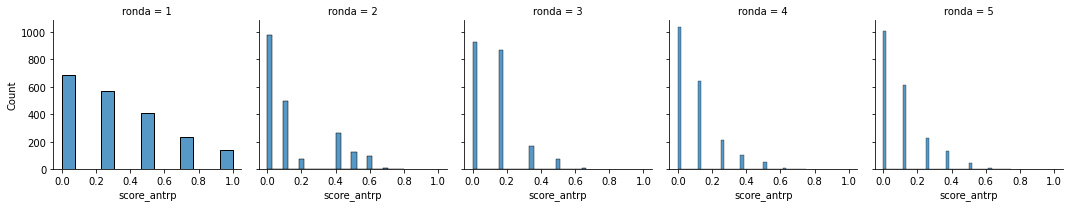

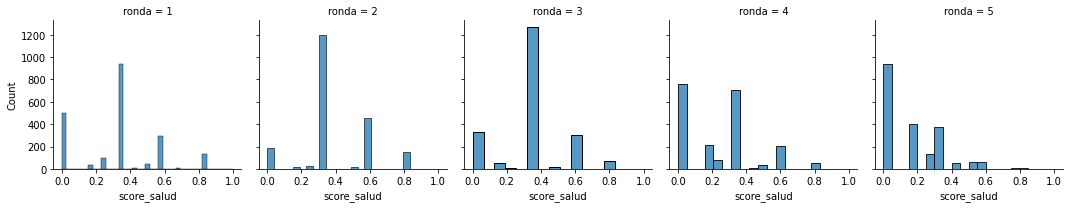

In [17]:

sns.FacetGrid(df_final, col = 'ronda').map(sns.histplot, 'risk')
sns.FacetGrid(df_final, col = 'ronda').map(sns.histplot, 'score_socioec') 
sns.FacetGrid(df_final, col = 'ronda').map(sns.histplot, 'score_antrp') 
sns.FacetGrid(df_final, col = 'ronda').map(sns.histplot, 'score_salud')

In [21]:
## Con el fin de analizar las trayectorias individuales se arma un dataset en donde la primary key es el childid
## y en cada columna esta el calculo de riesgo efectuado para cada ronda
risk_evolution = pd.DataFrame(df.childid.unique(),columns = ['childid'])
cols_to_keep = ['childid','score_antrp','score_salud','score_socioec','risk']

for i in dfs.keys():
    data_ronda = dfs[i].loc[:,cols_to_keep]
    data_ronda.columns = [j+'_'+str(i) if 'childid' not in j else j for j in cols_to_keep ]
    risk_evolution = pd.merge(risk_evolution,data_ronda, how = 'left', on = ['childid'])
        
print(risk_evolution.shape)
risk_evolution.head(5)

(2052, 21)


,childid,score_antrp_1,score_salud_1,score_socioec_1,risk_1,score_antrp_2,score_salud_2,score_socioec_2,risk_2,score_antrp_3,...,score_socioec_3,risk_3,score_antrp_4,score_salud_4,score_socioec_4,risk_4,score_antrp_5,score_salud_5,score_socioec_5,risk_5
0,PE011001,0.500,0.333,0.727,0.520,0.000,0.333,0.443,0.259,0.000,...,0.255,0.279,0.000,0.250,0.236,0.162,0.000,0.417,0.176,0.198
1,PE011002,0.000,0.333,0.526,0.286,0.400,0.333,0.341,0.358,0.167,...,0.282,0.261,0.125,0.333,0.206,0.221,0.125,0.333,0.287,0.248
2,PE011003,0.750,0.000,0.315,0.355,0.400,0.333,0.284,0.339,0.167,...,0.515,0.227,0.125,0.333,0.264,0.241,0.250,0.333,0.165,0.249
3,PE011004,0.500,0.000,0.220,0.240,0.400,0.333,0.209,0.314,0.167,...,0.232,0.244,0.000,0.000,0.262,0.087,0.125,0.000,0.254,0.126
4,PE011005,0.500,0.583,0.824,0.636,0.000,0.583,0.585,0.389,0.167,...,0.370,0.373,0.000,0.583,0.431,0.338,0.000,0.333,0.173,0.169


## 3d- Evolucion del riesgo total para cada una de las observaciones

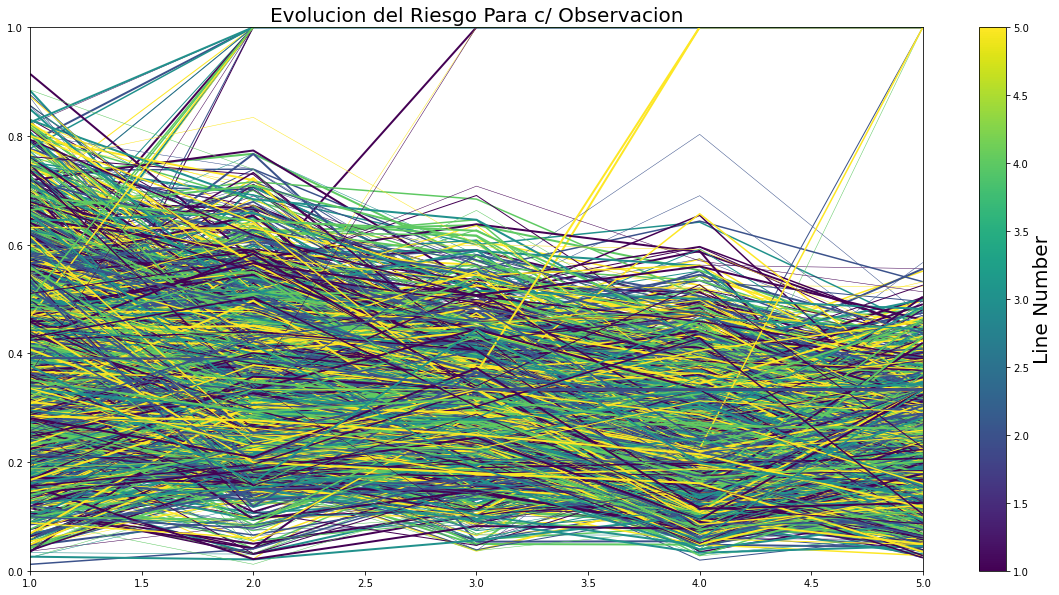

In [22]:
np.set_printoptions(suppress=True)

risk_per_round = risk_evolution.loc[:,['risk_1','risk_2','risk_3','risk_4','risk_5']]

x = np.arange(5)+1
ys = np.array(risk_per_round)
[np.column_stack([x, y]) for y in ys]

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlim(1, 5)
#ax.xticks([1, 2, 3, 4, 5])
ax.set_ylim(0, 1)

line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               linewidths=(0.5, 1, 1.5, 2),
                               linestyles='solid')
line_segments.set_array(x)
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Line Number', fontsize=20)
ax.set_title('Evolucion del Riesgo Para c/ Observacion', fontsize=20)
plt.sci(line_segments)  
plt.show()

## Armo el dataset para el entrenamiento
* saco columnas que repiten informacion del target
* separo en X e Y
* estandarizo variables
* relleno los NaN

In [ ]:
# DIVIDIR: NUMERICAS, DISCRETAS, CATEGORICAS DUMMY, ONEHOT ENCODING

admin = [ 'clustid','childid',"ronda","yc","panel12345","dint","agemon",'careid','dadid','headid','momid']
repeated_info = ["underweight" , "thinness", "drwaterq" , "toiletq" , "elecq" , "cookingq","bmi","zwfa","zhfa","zbfa","zwfl","fwfl","fhfa","fwfa","fbfa","momyrdied","dadyrdied",'hospital','chweight']
dependet = ["risk","risk_cat_1","risk_cat_2",'risk_cat_3',"risk_cat_4",'risk_cat_5']
other = ['placeid']
print(len(admin),len(repeated_info),len(dependet),len(other))


#"levlread", "levlwrit","engrade" , "enrol" refuse to answer. REVISAR.!!!!!!!!!!

cols_to_keep = ["inround",
                'agegr1','aniany','anibeeh','anicowm','anicowt','anidonk','anidrau',
                'anifish','anifshr','anigoat','aniguin','anillam','animilk','aniothr',
                'anioxen','anipigs','anipoul','anirabb','anirumi','anishee','anishri',
                'anisnai','anispec','bcg','beca_yl','birth','birth_age','bonograt','bwdoc',
                'bwght','careage','carecantread','caredu','careladder','caresex','chalcohol',
                'chdisability','chhealth','chhprob','childloc','chillness',
                'chinjury',"chsmoke",'chsex','cladder','commsch','commwork','credit',
                "chrephealth3","chrephealth2","chrephealth1","careldr4yrs",
                'dadcantread','dadedu','dadlive',"dadage",'delivery','dpt',
                "engrade","enrol",
                'female05','female1317','female1860','female61','female612','foodsec',
                'hcare','hchore','headage','headedudu','headsex','hhsize','hib',
                'hplay','hschool','hsleep','hstudy','htask','hwork',
                'insur_yl','juntos',
                'lang_raw',"literate","levlread","levlwrit",
                'male05','male1317','male1860','male61','male612',"marrcohab",'marrcohab_age','maths_raw','measles','minsa_yl',
                'momage','momcantread','momedu','momlive','numante','ownhouse','ownlandhse',
                'polio','ppvt_raw','preprim','projoven_yl',
                'rawscre','reading_raw','rscorelang_cog','rscorelang_ppvt','score_cog',
                'score_ppvt','shcrime1','shcrime2','shcrime3','shcrime4','shcrime5','shcrime6','shcrime8',
                'shecon1','shecon10','shecon11','shecon12','shecon14','shecon2','shecon3','shecon4','shecon5',
                'shecon6','shecon7','shecon8','shecon9','shenv1','shenv10','shenv11','shenv12','shenv2','shenv3',
                'shenv4','shenv5','shenv6','shenv7','shenv8','shenv9','shfam1','shfam10','shfam12','shfam13',
                'shfam14','shfam15','shfam16','shfam17','shfam18','shfam2','shfam3','shfam4','shfam5','shfam6',
                'shfam7','shfam8','shfam9','shhouse1','shhouse2','shhouse3','shother','shregul1','shregul2',
                'shregul4','shregul5','shregul6','sisgrat_yl','sppvt_raw','srawscre',
                'tetanus','typesite']

dummy_list = ["headrel_1","headrel_2","headrel_3","headrel_4","headrel_5","headrel_6","headrel_7","headrel_8","headrel_9","carerel_2","carerel_3","carerel_4","carerel_5","carerel_6","carerel_7","carerel_9","carehead_2","carehead_3","entype_2","entype_3","entype_4","chrephealth4_2","chrephealth4_3","chrephealth4_4","chdisscale_1","chdisscale_2","chdisscale_3","chdisscale_4","chdisscale_5","chdisscale_6","region_32","region_33","region_88"]

X_r1 = r1.loc[:,cols_to_keep + dummy_list]
y_r1 = r1.risk_cat_1

X_r2 = r2.loc[:,cols_to_keep + dummy_list]
y_r2 = r2.risk_cat_2

X_r3 = r3.loc[:,cols_to_keep + dummy_list]
y_r3 = r3.risk_cat_3

X_r4 = r4.loc[:,cols_to_keep + dummy_list]
y_r4 = r4.risk_cat_4

X_r5 = r5.loc[:,cols_to_keep + dummy_list]
y_r5 = r5.risk_cat_5


X_r1 = X_r1.fillna(0)
#x_train = x_train.loc[:,~(x_train.isnull().values.all(axis=0))] eliminar todas las columnas con null values


11 19 6 1


NameError: ignored

In [ ]:
print('cols_to_keep',len(cols_to_keep),'\n')
#print('still_need_work_to_include',len(still_need_to_work_on),'\n')

## Training


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_r1, y_r2, test_size=0.33, random_state=42)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train.loc[:,cols_to_keep])
X_train_scaled = scaler.transform(X_train.loc[:,cols_to_keep])
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled = pd.concat([X_train_scaled.reset_index(drop=True),X_train.loc[:,dummy_list].reset_index(drop=True)], axis = 1)
X_train_scaled.columns = pd.RangeIndex(start=0, stop=209, step=1)

scaler = preprocessing.StandardScaler().fit(X_test.loc[:,cols_to_keep])
X_test_scaled = scaler.transform(X_test.loc[:,cols_to_keep])
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled = pd.concat([X_test_scaled.reset_index(drop=True),X_test.loc[:,dummy_list].reset_index(drop=True)], axis = 1)
X_test_scaled.columns = pd.RangeIndex(start=0, stop=209, step=1)

print('train obs:',X_train_scaled.shape)
print('test obs:',X_test_scaled.shape)

In [ ]:
#check = ['bwght','careage','carecantread','caredu',"region_33.0"]
#cols_index = [X_train.columns.get_loc(col) for col in check]
#cols_index
#X_train.iloc[:,30:33].describe()
#X_train.iloc[:,30:33].head()
#X_train_scaled.iloc[:,30:33].head()

In [ ]:
results = train_and_evaluate_logit(X_train_scaled,
                                   y_train, 
                                   X_test_scaled,
                                   y_test,
                                   [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                   [0.001,0.01,0.1,1,5,10],
                                   'loo')
print(results)

results_df = pd.json_normalize(results)


for i in class_balance:
    y_binary = 
    for j in 
    

In [ ]:
results_df.sort_values(by=['test_auc'],ascending=False)

In [ ]:
results_df.shape

In [ ]:
y_train = np.where((y_train >= 7),1,0)
y_test = np.where((y_test >= 7),1,0)

In [ ]:
y_train.mean()

## Training Final

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Final Model Training



logit = LogisticRegression(solver = "liblinear", 
                               penalty = 'l1', \
                               C = 0.01) 
                               #fit_intercept=True)


logit.fit(X_train_scaled, y_train)


In [ ]:
# predigo probabilidades
y_test_prob = logit.predict_proba(X_test_scaled)[:,1:]
y_train_prob = logit.predict_proba(X_train_scaled)[:,1:]

## Metricas de Performance

In [ ]:
roc_curve_plot(y_train, y_train_prob, 'train')

In [ ]:
roc_curve_plot(y_test, y_test_prob, 'test')

In [ ]:
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)
y_dummy_predictions = dummy_majority.predict(X_test_scaled)
dummy_majority.score(X_test_scaled, y_test)

In [ ]:

y_test_pred = np.where(y_test_prob > 0.4,1,0)
y_actu = pd.Series(y_test, name='Actual')
y_test_pred2 = pd.DataFrame(y_test_pred, columns=['Predicted'])
df_confusion = pd.crosstab(y_actu, y_test_pred2.Predicted)
df_confusion

In [ ]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_test_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_test_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=['0', '1']))

In [ ]:
plt.hist(y_test_prob, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [ ]:

df_class_pred = pd.concat([y_actu,pd.DataFrame(y_test_prob, columns = ['Predicted'])],axis = 1)
df_class_pred.head()

In [ ]:
sns.histplot(data=df_class_pred, x="Predicted", hue="Actual")

#### Interpretación

In [ ]:
coef_dict = {}
for coef, feat in zip(logit.coef_[0,:],X_r1.columns):
    coef_dict[feat] = coef
    

    
coef_dict
dict(sorted(coef_dict.items(), key=lambda item: item[1]))

In [ ]:
coefs = pd.DataFrame(coef_dict.items(), columns=['Feature', 'Coeficient'])
coefs.head()

In [ ]:
coefs = pd.DataFrame(coef_dict.items(), columns=['Feature', 'Coeficient'],index=coef_dict.keys())
coefs = coefs[coefs.Coeficient != 0]
coefs.plot.barh(figsize=(9, 7))
plt.title("L1 Logit, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Variabilidad de Coeficientes

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = LeaveOneOut()
cv_model = cross_validate(
    logit,
    X_train_scaled,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)


In [ ]:
check = ['momedu','typesite','delivery']
cols_index = [X_train.columns.get_loc(col) for col in check]
cols_index

In [ ]:
print('Tener en cuenta que se excluyo una dummy del set')
print('mother education')
X_train_scaled.iloc[:,98]
X_train_scaled.iloc[:,98].value_counts()

In [ ]:
print('attended by health professional')
X_train_scaled.iloc[:,175].value_counts()

In [ ]:
print('urban or rural')
X_train_scaled.iloc[:,57]
X_train_scaled.iloc[:,57].value_counts()